In [1]:
# Python 3.9. Anaconda recommended.
# -- Prerequisites install 
#%pip install ipykernel --user
#%pip install stable_baselines3 --user
#%pip install tensorboard --user
#%pip install torch --index-url https://download.pytorch.org/whl/cu117 --upgrade --force-reinstall --trusted-host pypi.org --trusted-host pytorch.org --trusted-host download.pytorch.org --no-cache --user


# STABLEBASELINES TESTBED

In [1]:
# Battery env 
import gymnasium as gym
import numpy as np
from typing import Optional, Union
import itertools
import math


import sys
sys.path.append('../../battery-modeling/Step 3. Simulation')

import sys
sys.path.append('../../battery-modeling/Step 3. Simulation')

import SimCellPack as scp



#class BatteryEnv(gym.Env[np.ndarray, Union[int, np.ndarray]]):

class BatteryEnv(gym.Env):

   def __init__(self, numCells, simCycles, sampleFactor, render_mode: Optional[str] = None):
      super().__init__()

      self.env_id = "Battery v0.4"
      self.num_envs = 1

      self.numCells = numCells

      # Define cell model simualtor 
      self.cellModel = scp.SimCellPack(numCells = numCells, simCycles = simCycles, sampleFactor = sampleFactor)
      self.cellModel.startSim()

   
      self.soc_threshold_upper = 0.85
      self.soc_threshold_lower = 0.15


      self.action_space = gym.spaces.Box(-1, 1, (self.numCells,), dtype=np.float32)       # current applied to cell1,cell2,cell3...
      self.observation_space = gym.spaces.Box(0, 1, (self.numCells,), dtype=np.float32)   # SOCs for cell1, cell2, cell3...


      self.episode_time = 0
      self.state = None
      



   def step(self, action):
      err_msg = f"{action!r} ({type(action)}) invalid"
      assert self.action_space.contains(action), err_msg
      assert self.state is not None, "Call reset before using step method."

      # Scale the action space between 0 and 1
      battery_current_values = get_converted_action(action)

      # Send the action as feedback to the cell model
      self.cellModel.sendSimFeedback(battery_current_values)

      # Flags for determining certain occurences
      terminated = False
      truncated = False

      #Apply action to state
      code, self.state = self.cellModel.getSimStep()

      #print("Step: state: " + str(self.state) + " code: " + str(code))

      # Cell simulation finished, terminate
      if code == 0.0:
         truncated = True

      # Compute reward and termination cases
      # Apply step reward. Continue running.
      reward = compute_ballancing_reward(self.state, battery_current_values, False)

      # Return modified
      return np.array(self.state, dtype=np.float32), float(reward), terminated, truncated, {}

   def reset(self, *, seed: Optional[int] = None, options: Optional[dict] = None,):
   # Reset runs first before starting the simulation to get the initial states
        
      super().reset(seed=seed)

      # Stops and restarts the cell simulation
      self.cellModel.resetSim()


      self.episode_time = 0

      # Get initial states from the cell model
      code, self.state = self.cellModel.getSimStep()

      #print("Reset state: " + str(self.state))

      return np.array(self.state, dtype=np.float32), {}
   

   def __del__(self):
      self.cellModel.stopSim()



#CONVERT ACTION
   
def get_converted_action(action):
   current_values = []
   for current in action:
      shifted_value = ((current + 1.0))/2  #from [-1, 1] to [0, 1], to be reduced from SoC
      current_values.append(shifted_value)

   return current_values


# REWARD CALCULATION HELPERS 

def compute_closeness(socs):
   mean = 0
   for soc in socs:
      mean += soc
   mean = mean/len(socs)

   mean_diff = 0
   for  soc in socs:
      mean_diff += abs(mean - soc)

   mean_diff /= len(socs)

   min = np.array(socs).min()
   max = np.array(socs).max()
   abs_diff_min_max = max - min


   # alternative: (mean_diff), or (mean_diff*05 + abs_diff_min_max*0.5)
   return abs_diff_min_max

# Closeness function debug code
numbers = [0.02, 0.05, 0, 0.01, 0.1]
numbers = [0.8268956, 0.7947008, 0.8274856]
print(compute_closeness(numbers))
print(np.std(numbers, dtype=np.float32))  # standard deviation

# Get reward for a given step
def compute_ballancing_reward(socs, action, should_print):

   # ---- REWARD ALTERNATIVES ----

   # 1. Cost as distance between 2 numbers. Yang
   #reward = -pow(soc0 - soc1, 2)
      
   # 2. Cost as standard deviation
   # reward = -np.std(socs, dtype=np.float32)

   # ---- REWARD ALTERNATIVES ----




   # normalized_socs = []
   # for soc in socs:
   #    newsoc = (soc - min(socs)) / (max(socs) - min(socs))
   #    normalized_socs.append(newsoc)
   
   # SOCs are now between [0, 1]


   reward = 0

   index_min_soc = socs.index(min(socs))

   # reduce reward for any actions on the minimum SOC
   if action[index_min_soc] != 0.0:
      # reward -= 0.01
      reward = -action[index_min_soc]
   
   else:
      # give 0.01 for each SOC that is within 0.01 distance of the smallest SOC.
      non_min_soc_indexes = list(range(len(socs)))
      non_min_soc_indexes.remove(index_min_soc)

      # for i in non_min_soc_indexes:
      #    if (math.isclose(min(socs), socs[i], abs_tol=0.001)):
      #       # reward += 0.01
      #       reward += 1

      
   # Introduce closeness to the reward. Penalty = abs ( maxsoc - minsoc )
   reward = reward - compute_closeness(socs)*100

   # introduce exponential reward? the farther the SOCs get, cost increases exponentially
             
   return reward


print("-----------")
print(compute_ballancing_reward([0.56971985, 0.55291414, 0.55013263], [0.0, 0.5, 0.8], False))
print(compute_ballancing_reward([0.36923957, 0.3938384, 0.40389347], [0.0, 0.0, 0.0], False))
print(compute_ballancing_reward([0.8429049, 0.8430514, 0.8428894], [0., 0., 0.], False))
print(compute_ballancing_reward([0.8429049, 0.8390514, 0.8428894], [0., 0., 0.], False))
print(compute_ballancing_reward([0.7342201, 0.7251791, 0.7474329], [0., 0., 0.], False))
print(compute_ballancing_reward([0.7555555, 0.7555555, 0.7555555], [0., 0., 0.], False))



0.03278480000000006
0.0153177325
-----------
-2.7587220000000015
-3.4653899999999958
-0.016199999999999548
-0.3853499999999954
-2.225379999999999
0.0


# PLOTTING FUNCTIONS:

In [14]:
print(compute_ballancing_reward([0.56971985, 0.55291414, 0.55013263], [0.0, 0.5, 0.0], False))
print(compute_ballancing_reward([0.36923957, 0.3938384, 0.40389347], [0.0, 0.0, 0.0], False))
print(compute_ballancing_reward([0.8429049, 0.8430514, 0.8428894], [0., 0., 0.], False))
print(compute_ballancing_reward([0.7342201, 0.7251791, 0.7474329], [0., 0., 0.], False))

-1.9587220000000016
-3.4653899999999958
1.9838000000000005
-2.225379999999999


In [2]:
import matplotlib.pyplot as plt
from IPython import display



def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, "valid")


def plot_results(log_folder, title="Learning Curve"):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), "timesteps")
    y = moving_average(y, window=1)
    # Truncate x
    x = x[len(x) - len(y) :]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel("Number of Timesteps")
    plt.ylabel("Rewards")
    plt.title(title + " Smoothed")
    # plt.show()

    display.clear_output(wait=True)
    display.display(plt.gcf())

# plot_results(log_dir)


In [3]:
import stable_baselines3
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback


import os
import torch
import numpy as np
from typing import Optional, Union




class PlotResultsCallback(BaseCallback):

    def __init__(self, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.log_dir = log_dir
        self.save_path = None

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        plot_results(self.log_dir)

        return True
    
    



# Initialize environment

In [4]:
# !pip install gymnasium[box2d]
import gymnasium as gym
from stable_baselines3.common.env_checker import check_env


# Create log dir
log_dir = "./tmp/gym/pponormtest/"
os.makedirs(log_dir, exist_ok=True)


# Create and wrap the environment
env = BatteryEnv(numCells = 3, simCycles = 15, sampleFactor = 15, render_mode = False)

#for i in range(0, 100):
#    check_env(env)


# Logs will be saved in log_dir/monitor.csv 
env = Monitor(env, log_dir) #monitor for raw environments





# Opt1: Initialize a new model

In [5]:
from stable_baselines3 import A2C, SAC, PPO, TD3


print("Is CUDA enabled?", torch.cuda.is_available())


# model = PPO('MlpPolicy', env, verbose=1, device="cuda", tensorboard_log="./pponorm_tensorboard_log/", stats_window_size=3, gamma=0.8)

model = PPO('MlpPolicy', env, verbose=1, device="cuda", tensorboard_log="./pponorm_tensorboard_log/")



Is CUDA enabled? True
Using cuda device
Wrapping the env in a DummyVecEnv.


# Opt 2: Load existing trained model from save file

In [5]:
from stable_baselines3 import A2C, SAC, PPO, TD3

model = PPO.load(env=env, path=os.path.join(log_dir, "best_model_ppo_batterysim_30000"))

Wrapping the env in a DummyVecEnv.


Train model for X timesteps.
Can be interrupted and retain training.

In [7]:
callback = EvalCallback(env, log_path=log_dir, n_eval_episodes= 1, eval_freq= 50000,
                            best_model_save_path=os.path.join(log_dir, "best_model_ppo_norm"))

In [25]:
from stable_baselines3.common import results_plotter
from stable_baselines3 import A2C, SAC, PPO, TD3


# callback = EvalCallback(env, log_path=log_dir, n_eval_episodes= 1, eval_freq= 15000,
#                             best_model_save_path=os.path.join(log_dir, "best_model_ppo_norm"),
#                             callback_on_new_best=PlotResultsCallback(log_dir=log_dir))

# callback = EvalCallback(env, log_path=log_dir, n_eval_episodes= 1, eval_freq= 15000,
#                             best_model_save_path=os.path.join(log_dir, "best_model_ppo_norm"))

# Eval callback, for plotting and seeing how the training is going, and saving best models. No effect on the results.

# model.learn(total_timesteps=int(10000000), callback=callback)

for i in range (0, 10):
    model.learn(total_timesteps=int(300000), callback=callback)



# Plot helper from the library
results_plotter.plot_results(
    [log_dir], 1e7, results_plotter.X_TIMESTEPS, "PPO - Env: Battery"
)

# only ballance during resting
# during resting SOC is more accurate in estimation
# its also dangerous to do it during working times

# use larger SOC cells more AND use smallest SOC less4


# with Power Electronics, the output voltage has been changed.

# do ballancing while it rests



# !!!!!!!!!! You should know that PPO1 and TRPO update self.num_timesteps after each rollout (and not each step) because they rely on MPI.

Logging to ./pponorm_tensorboard_log/PPO_109
-----------------------------
| time/              |      |
|    fps             | 344  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 316         |
|    iterations           | 2           |
|    time_elapsed         | 12          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.004151674 |
|    clip_fraction        | 0.0291      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.88       |
|    explained_variance   | 0.88        |
|    learning_rate        | 0.0003      |
|    loss                 | 194         |
|    n_updates            | 3440        |
|    policy_gradient_loss | -0.00358    |
|    std                  | 0.635       |
|    value_loss           | 487

KeyboardInterrupt: 

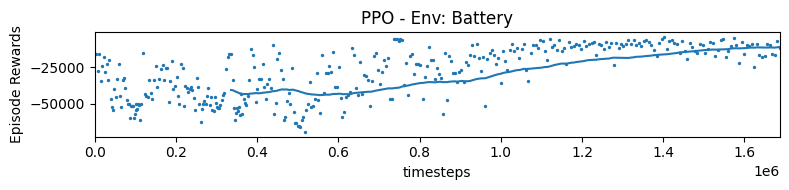

In [27]:

results_plotter.plot_results(
    [log_dir], 1e7, results_plotter.X_TIMESTEPS, "PPO - Env: Battery"
)

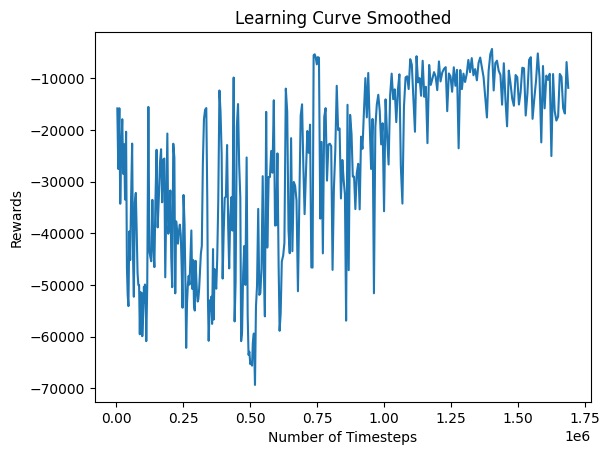

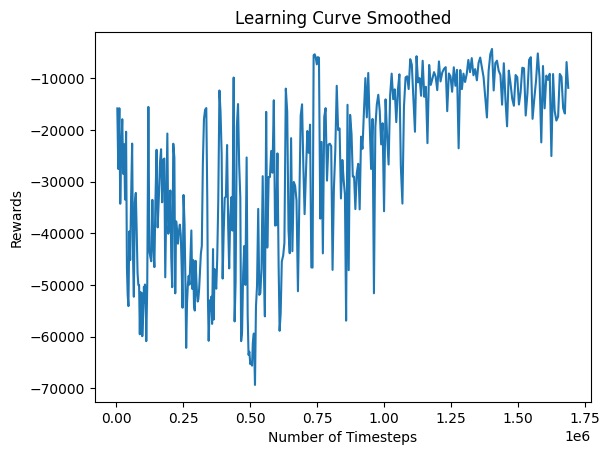

In [28]:

plot_results(log_dir)

# Test 1 episode of the model

In [26]:
model.save(os.path.join(log_dir, "best_model_ppo_batterysim_50000bad"))

[-0.00331881]
[[0.8477357 0.847752  0.8477188]]  ACTION:[0. 0. 0.]  >>>>    REWARD:  [-0.00331881]   
[-0.00458366]
[[0.8467987  0.84682035 0.8467745 ]]  ACTION:[0. 0. 0.]  >>>>    REWARD:  [-0.00458366]   
[-0.37275982]
[[0.84423625 0.8439052  0.8444279 ]]  ACTION:[0.12283549 0.32049534 0.        ]  >>>>    REWARD:  [-0.37275982]   
[-0.5493074]
[[0.84223866 0.84192187 0.8415062 ]]  ACTION:[0.         0.         0.47605515]  >>>>    REWARD:  [-0.5493074]   
[-0.07314622]
[[0.8424357  0.84211504 0.84170425]]  ACTION:[0. 0. 0.]  >>>>    REWARD:  [-0.07314622]   
[-0.4182959]
[[0.8421167 0.8417962 0.8408293]]  ACTION:[0.        0.        0.2895522]  >>>>    REWARD:  [-0.4182959]   
[-0.29192138]
[[0.838909  0.8394932 0.8381846]]  ACTION:[0.4683342  0.         0.16105986]  >>>>    REWARD:  [-0.29192138]   
[-0.48088017]
[[0.8374759  0.83864343 0.836764  ]]  ACTION:[0.30522904 0.         0.29293242]  >>>>    REWARD:  [-0.48088017]   
[-0.37655926]
[[0.8351953 0.8364645 0.8342555]]  ACTION:

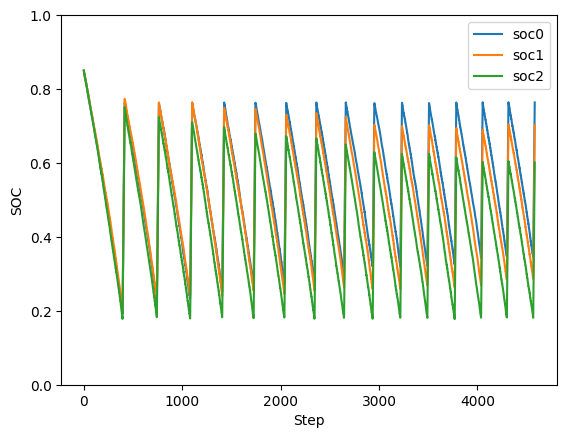

In [18]:
from stable_baselines3 import A2C, SAC, PPO, TD3
import os

# model.save(os.path.join(log_dir, "best_model_ppo_batterysimm"))

# eval_env = BatteryEnv(numCells = 3, simCycles = 2, sampleFactor = 10, render_mode = False)
# model = PPO.load(env=eval_env, path=os.path.join(log_dir, "best_model_ppo_batterysim"))

# def test_trained_model():
obs = model.get_env().reset()
episode_reward = 0

obsArray = []

while True:
    obsArray.append(obs)
    action, _states = model.predict(obs)
    # oldObs = obs
    obs, rewards, done, info = model.get_env().step(action)
    print(rewards)
    episode_reward += rewards.squeeze()

    if not done:
        print(str(obs) + "  ACTION:" + str(get_converted_action(action)[0]) + "  >>>>  " + "  REWARD:  "  + str(rewards) + "   ")
    else:
        info_item = info.pop()
        print("FINAL: ")
        print(str(info_item.get('terminal_observation'))  + "       ACTION:" )
        print(str(str(get_converted_action(action.flatten()))))
        print("REWARD:  " + str(rewards[0]))
        print("EPISODE TOTAL REWARD: " + str(episode_reward))

        # plot final model
        fig = plt.figure(1)

        data_np = np.array(obsArray)

        plt.xlabel('Step')
        plt.ylabel('SOC')
        print("------------------------------------------------------")
        plt.ylim([0, 1])


        i = 0
        for soc in data_np.T:
            plt.plot(np.arange(start=0, stop=len(data_np), step=1), soc.flatten(), label="soc"+str(i))
            i += 1

        plt.legend()
        #plt.pause(3)

        # obsArray = []
        # episode_reward = 0
        obs = model.get_env().reset()

        #time.sleep(0.5)
        break


# Add SOC Difference christmas tree to this plot

# test_trained_model()


In [19]:
print(len(obsArray))

21559


### Sanity check. See if running the simulation with no action from the model gives us similar results

[[0.8467312  0.84677386 0.84676266]]  ACTION:[0.         0.03692839 0.06533337]  >>>> 
  REWARD:  [-0.5042703]   
[[0.84481186 0.8448803  0.84486204]]  ACTION:[0.         0.25804374 0.06709737]  >>>> 
  REWARD:  [-0.50683933]   
[[0.8414779  0.84158903 0.84155977]]  ACTION:[0.52043736 0.30245566 0.        ]  >>>> 
  REWARD:  [-0.51112014]   
[[0.8384805 0.8386307 0.8385912]]  ACTION:[0. 0. 0.]  >>>> 
  REWARD:  [-0.5150225]   
[[0.8377153 0.8378762 0.8378336]]  ACTION:[0.18466505 0.11883199 0.        ]  >>>> 
  REWARD:  [-0.5160849]   
[[0.83642393 0.83660275 0.83655494]]  ACTION:[0.         0.10980612 0.        ]  >>>> 
  REWARD:  [-0.5178832]   
[[0.8330978 0.8333201 0.8332609]]  ACTION:[0.         0.01512527 0.        ]  >>>> 
  REWARD:  [-0.5222232]   
[[0.8312622  0.83150905 0.83144313]]  ACTION:[0.        0.        0.1191971]  >>>> 
  REWARD:  [-0.52468926]   
[[0.8280643  0.8283523  0.82827574]]  ACTION:[0.0301441 0.        0.       ]  >>>> 
  REWARD:  [-0.528792]   
[[0.8249079

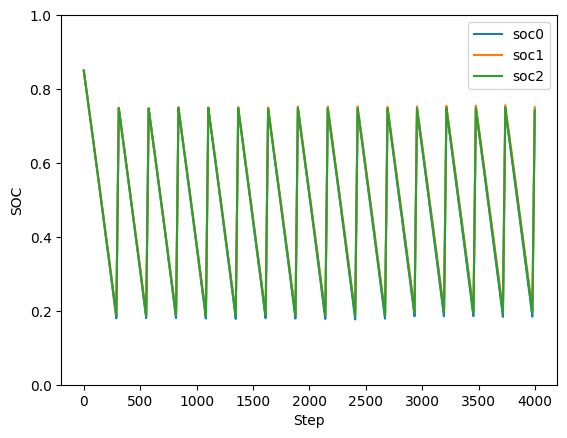

In [24]:
def test_trained_model_no_action():
    obs = model.get_env().reset()
    episode_reward = 0

    obsArray = []

    while True:
        obsArray.append(obs)
        action, _states = model.predict(obs)
        # oldObs = obs
        obs, rewards, done, info = model.get_env().step([[0., 0., 0.]])
        episode_reward += rewards.squeeze()

        if not done:
            print(str(obs) + "  ACTION:" + str(get_converted_action(action)[0]) + "  >>>> ")
            print("  REWARD:  "  + str(rewards) + "   ")
        else:
            info_item = info.pop()
            print("FINAL: ")
            print(str(info_item.get('terminal_observation'))  + "       ACTION:" )
            print(str(str(get_converted_action(action.flatten()))))
            print("REWARD:  " + str(rewards[0]))
            print("EPISODE TOTAL REWARD: " + str(episode_reward))

            # plot final model
            fig = plt.figure(1)

            data_np = np.array(obsArray)

            plt.xlabel('Step')
            plt.ylabel('SOC')
            print("------------------------------------------------------")
            plt.ylim([0, 1])


            i = 0
            for soc in data_np.T:
                plt.plot(np.arange(start=0, stop=len(data_np), step=1), soc.flatten(), label="soc"+str(i))
                i += 1

            plt.legend()
            #plt.pause(3)

            # obsArray = []
            # episode_reward = 0
            obs = model.get_env().reset()

            #time.sleep(0.5)
            break




test_trained_model_no_action()